In [19]:
from datasets import load_dataset;

In [20]:
#Getting the katanml/cord dataset
datasets = load_dataset("katanaml/cord");
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['id', 'words', 'bboxes', 'ner_tags', 'image_path'],
        num_rows: 100
    })
})

In [21]:
#Ini aku menjadi target
labels = datasets['train'].features['ner_tags'].feature.names
labels

['O',
 'I-menu.cnt',
 'I-menu.discountprice',
 'I-menu.nm',
 'I-menu.num',
 'I-menu.price',
 'I-menu.sub_cnt',
 'I-menu.sub_nm',
 'I-menu.sub_price',
 'I-menu.unitprice',
 'I-sub_total.discount_price',
 'I-sub_total.etc',
 'I-sub_total.service_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.tax_price',
 'I-total.cashprice',
 'I-total.changeprice',
 'I-total.creditcardprice',
 'I-total.emoneyprice',
 'I-total.menuqty_cnt',
 'I-total.menutype_cnt',
 'I-total.total_etc',
 'I-total.total_price']

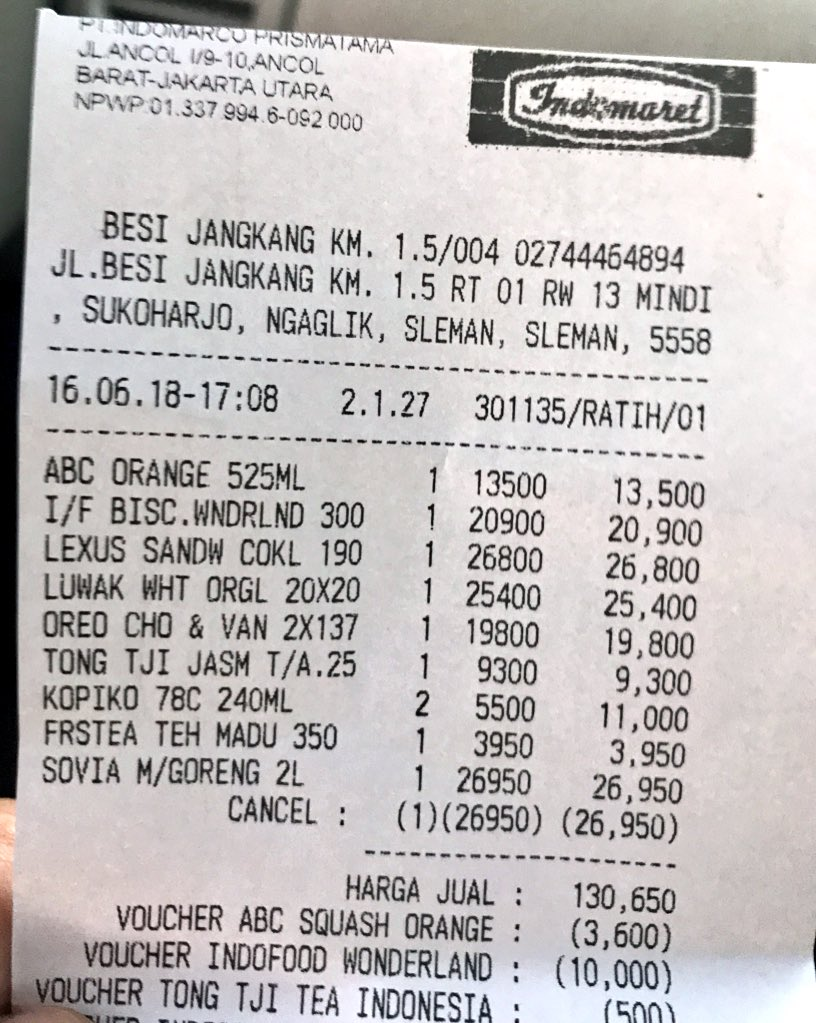

In [22]:
from PIL import Image
image = Image.open('./Dfzj8LIU8AAki-Z.jpg')
image = image.convert("RGB")
image

In [23]:
words = ["PINDOMARCOPRISMATAMA","JLANCOL9-10ANCOL","BARAT-JAKARTA UTARA","Indrmaret","NPWP01.337994.6-092000","BESI JANGKANG KM.1.5/004 02744464894","JL.BESI JANGKANG KM.1.5 RT 01 RW 13 MINDI","SUKOHARJONGAGLIKSLEMANSLEMAN5558","16.06.18-17:08","2.1.27","301135/RATIH/01","ABC ORANGE 525ML","1","13500","13,500","I/F BISC.WNDRLND 300","1","20900","20,900","LEXUS SANDW COKL 190","1","26800","26,800","LUWAK WHT ORGL 20X20","1","25400","25,400","OREOCHO &VAN 2X137","1","19800","19,800","TONG TJI JASM T/A.25","1","9300","9,300","KOPIK078C240ML","2","5500","11,000","FRSTEATEH MADU 350","3950","3,950","SOVIA M/GORENG 2L","126950","26,950","CANCEL:","12695026,950)","HARGA JUAL","130,650","VOUCHER ABC SQUASH ORANGE :","3,600","VOUCHER INDOFOOD WONDERLAND:10,000)","VOUCHER TONG TJI TEA INDONESTA:","(500)"]
bbox = [[98,12,480,53],[96,36,395,75],[94,59,405,100],[628,72,865,128],[91,85,442,130],[125,202,837,270],[63,241,873,308],[73,283,871,351],[58,364,338,403],[412,373,528,410],[582,382,862,422],[53,443,368,478],[522,451,541,481],[577,453,670,489],[750,460,865,501],[55,481,446,518],[519,490,539,518],[572,489,669,526],[743,498,862,536],[52,521,442,554],[519,526,534,553],[571,525,665,563],[741,534,857,574],[51,558,441,590],[514,562,535,589],[567,562,665,600],[737,570,854,610],[52,595,435,626],[513,597,530,627],[569,599,661,636],[737,608,851,647],[52,631,436,662],[507,634,533,665],[580,635,660,672],[748,645,850,684],[52,667,355,695],[503,670,531,702],[579,672,656,708],[732,683,844,718],[53,701,412,731],[577,708,655,745],[745,718,841,753],[51,737,372,769],[500,741,653,781],[725,752,838,787],[278,773,432,808],[484,779,830,824],[424,854,639,885],[700,858,828,895],[143,878,640,921],[694,894,825,931],[100,910,825,972],[45,952,638,997],[737,971,829,999]]
print(len(words), len(bbox))

54 54


In [24]:
from transformers import LayoutLMv2Processor

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

encoded_inputs = processor(image, words, boxes=bbox, return_offsets_mapping=True, return_tensors="pt")
offset_mapping = encoded_inputs.pop('offset_mapping')

In [25]:
encoded_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'image'])

In [26]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)
len(encoded_inputs)

5

In [27]:
from transformers import LayoutLMv2ForTokenClassification

# load the fine-tuned model from the hub
model = LayoutLMv2ForTokenClassification.from_pretrained("katanaml/layoutlmv2-finetuned-cord")
id2label = model.config.id2label
model.to(device)

# forward pass
outputs = model(**encoded_inputs)
print(outputs.logits.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


torch.Size([1, 295, 23])


In [28]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

In [29]:
processor.tokenizer.batch_decode(encoded_inputs.input_ids)

['[CLS] pindomarcoprismatama jlancol9 - 10ancol barat - jakarta utara indrmaret npwp01. 337994. 6 - 092000 besi jangkang km. 1. 5 / 004 02744464894 jl. besi jangkang km. 1. 5 rt 01 rw 13 mindi sukoharjongaglikslemansleman5558 16. 06. 18 - 17 : 08 2. 1. 27 301135 / ratih / 01 abc orange 525ml 1 13500 13, 500 i / f bisc. wndrlnd 300 1 20900 20, 900 lexus sandw cokl 190 1 26800 26, 800 luwak wht orgl 20x20 1 25400 25, 400 oreocho & van 2x137 1 19800 19, 800 tong tji jasm t / a. 25 1 9300 9, 300 kopik078c240ml 2 5500 11, 000 frsteateh madu 350 3950 3, 950 sovia m / goreng 2l 126950 26, 950 cancel : 12695026, 950 ) harga jual 130, 650 voucher abc squash orange : 3, 600 voucher indofood wonderland : 10, 000 ) voucher tong tji tea indonesta : ( 500 ) [SEP]']

In [30]:
import numpy as np

is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0

true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]

In [31]:
true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
print(len(true_predictions))
true_predictions

56


['I-menu.nm',
 'I-menu.nm',
 'I-menu.nm',
 'I-menu.nm',
 'I-menu.nm',
 'I-menu.discountprice',
 'I-menu.num',
 'I-menu.nm',
 'I-menu.nm',
 'I-menu.discountprice',
 'I-menu.discountprice',
 'I-menu.num',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.num',
 'I-menu.cnt',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.unitprice',
 'I-menu.price',
 'I-menu.nm',
 'I-menu.unitprice',
 'I-menu.price',
 'I-total.changeprice',
 'I-total.total_price',
 'I-sub_total.subtotal_price',
 'I-sub_total.subtotal_price',
 'I-total.total_etc',
 'I-total.total_etc',
 'I-total.total_etc',
 'I-total.total_etc',
 'I-total.total_etc',
 'I

In [79]:
predicted_boxes = [[box, width, height] for idx, box in enumerate(token_boxes) if not is_subword[idx]]
mapping = []
for index, (t) in enumerate(predicted_boxes):
    box = t[0]
    if box in bbox:
        word_index = bbox.index(box)
        mapping.append((words[word_index], true_predictions[index][2:]))
mapping
        

[('PINDOMARCOPRISMATAMA', 'menu.nm'),
 ('JLANCOL9-10ANCOL', 'menu.nm'),
 ('BARAT-JAKARTA UTARA', 'menu.nm'),
 ('Indrmaret', 'menu.nm'),
 ('NPWP01.337994.6-092000', 'menu.discountprice'),
 ('BESI JANGKANG KM.1.5/004 02744464894', 'menu.num'),
 ('JL.BESI JANGKANG KM.1.5 RT 01 RW 13 MINDI', 'menu.nm'),
 ('SUKOHARJONGAGLIKSLEMANSLEMAN5558', 'menu.nm'),
 ('16.06.18-17:08', 'menu.discountprice'),
 ('2.1.27', 'menu.discountprice'),
 ('301135/RATIH/01', 'menu.num'),
 ('ABC ORANGE 525ML', 'menu.nm'),
 ('1', 'menu.cnt'),
 ('13500', 'menu.unitprice'),
 ('13,500', 'menu.price'),
 ('I/F BISC.WNDRLND 300', 'menu.nm'),
 ('1', 'menu.cnt'),
 ('20900', 'menu.unitprice'),
 ('20,900', 'menu.price'),
 ('LEXUS SANDW COKL 190', 'menu.nm'),
 ('1', 'menu.cnt'),
 ('26800', 'menu.unitprice'),
 ('26,800', 'menu.price'),
 ('LUWAK WHT ORGL 20X20', 'menu.nm'),
 ('1', 'menu.cnt'),
 ('25400', 'menu.unitprice'),
 ('25,400', 'menu.price'),
 ('OREOCHO &VAN 2X137', 'menu.nm'),
 ('1', 'menu.cnt'),
 ('19800', 'menu.unitpric

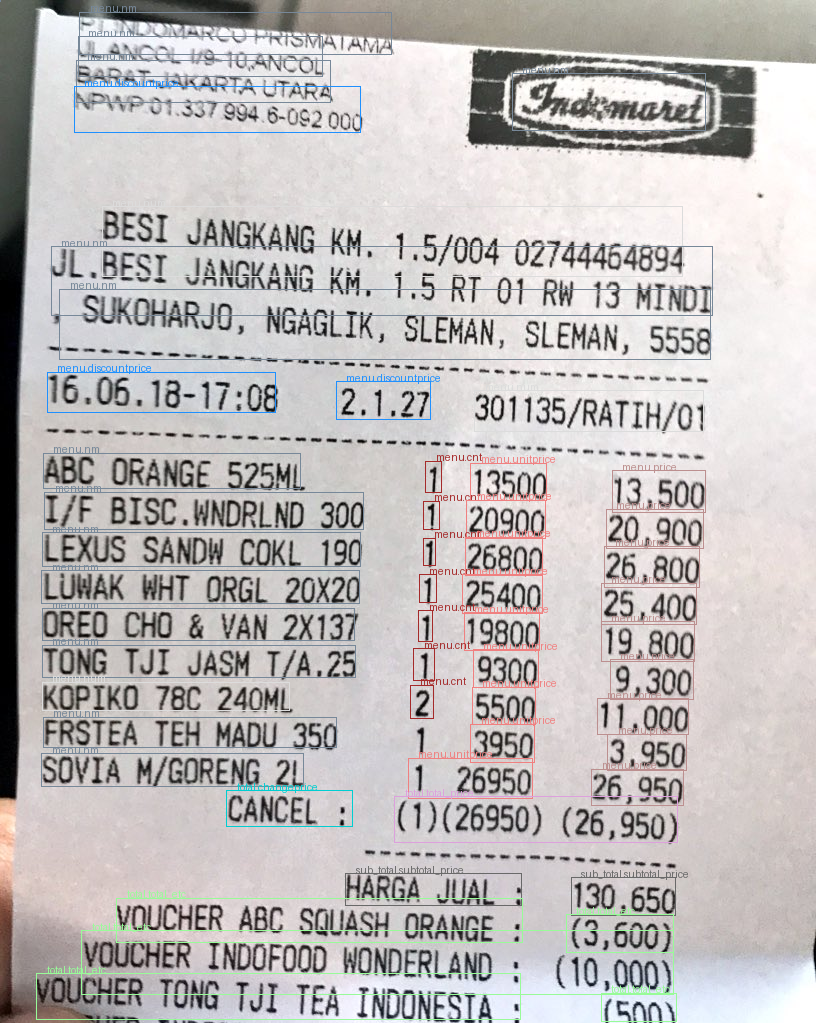

In [33]:
from PIL import ImageDraw, ImageFont
import numpy as np
import PIL

draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'o'
    return label

label_ints = np.random.randint(0,len(PIL.ImageColor.colormap.items()),30)

label_color_pil = [k for k,_ in PIL.ImageColor.colormap.items()]
	
label_color = [label_color_pil[i] for i in label_ints]
label2color = {}
for k,v in id2label.items():
  if v[2:] == '':
    label2color['o']=label_color[k]
  else:
    label2color[v[2:]]=label_color[k]

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image